In [1]:
import sys
sys.path.append('/home/samuelboehm/reworkedGAN/EEG-GAN/GAN/Data')

import matplotlib.pyplot as plt
import numpy as np

import joblib

from braindecode.models.deep4 import Deep4Net
from braindecode import EEGClassifier

from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from skorch.dataset import Dataset as skDataset

import torch

In [2]:
data = torch.load('/home/samuelboehm/reworkedGAN/Data/clinical')

channels = ['Fp1','Fp2','F7','F3','Fz','F4','F8',
            'T7','C3','Cz','C4','T8','P7','P3',
            'Pz','P4','P8','O1','O2','M1','M2']

In [31]:
splits = data.return_from_tag('split')

test_idx = splits['idx'][splits.split == 'test'].values[0]
train_idx = splits['idx'][splits.split == 'train'].values[0]

In [41]:
valid_set = skDataset(data[test_idx][0], data[test_idx][1])
train_set = skDataset(data[train_idx][0], data[train_idx][1])

In [42]:


cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmarch = True

n_classes = 2
n_chans = len(channels)
input_window_samples = train_set[0][0].shape[1]

model = Deep4Net(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto'
)

if cuda:
    model.cuda()



clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)


In [43]:
clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.5162        1.0160            0.5027        0.8577  0.0100  7.8251
      2            0.6645        0.6988            0.6446        0.6873  0.0100  3.8404
      3            0.7442        0.6493            0.7054        0.5612  0.0100  3.8938
      4            0.8282        0.5661            0.8232        0.3980  0.0100  3.8652
      5            0.8920        0.3902            0.8964        0.2604  0.0100  3.8280
      6            0.8890        0.3048            0.8946        0.2671  0.0100  3.9149
      7            0.9112        0.2835            0.9098        0.2133  0.0100  3.9271
      8            0.9319        0.2520            0.9259        0.1815  0.0100  3.9369
      9            0.9424        0.2385            0.9339        0.1692  0.0100  3.8614
     10            0.9465       

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=Deep4Net(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=transpose_time_to_spat) 
    (conv_time): Conv2d(1, 25, kernel_size=(10, 1), stride=(1, 1))
    (conv_spat): Conv2d(25, 25, kernel_size=(1, 21), stride=(1, 1), bias=False)
    (bnorm): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_nonlin): Expression(expression=elu) 
    (pool): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
    (pool_nonlin): Expression(expression=identity) 
    (drop_2): Dropout(p=0.5, inplace=False)
    (conv_2): Conv2d(25, 50, kernel_size=(10, 1), stride=(1, 1), bias=False)
    (bnorm_2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin_2): Expression(expression=elu) 
    (pool_2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
    (pool_nonlin_2): Expressio

In [14]:
def plot_time_domain(real, fake, channel_names, path):
    
    cm = 1/2.54  # centimeters in inches
    _, axs = plt.subplots(3, 7,  figsize=(40*cm, 20*cm), facecolor='w')
    x = np.linspace(-.5, 2.5, num = fake.shape[2])

    for i, ax in enumerate(axs.flatten()):
        if channel_names:
            ax.text(.94, .94, channel_names[i], fontsize=12, ha='right', va='top', transform=ax.transAxes,
            bbox={'facecolor': 'white', 'alpha': 0.4, 'pad': 4})
        
        real_mean = real.mean(axis = 0)
        fake_mean = fake.mean(axis = 0)

        stack = np.concatenate((real_mean, fake_mean))
        ax.plot(x, real_mean[i], c='#c1002a', label ='real', lw = 1)
        ax.plot(x, fake_mean[i], c='#004a99', label='fake', lw = 1)
        
        max_y = stack.max() + stack.max() * .1
        min_y = stack.min() + stack.min() * .1

        ax.set_ylim(bottom=min_y, top=max_y)
        # ax.fill_between(x, fake.mean(axis = 0)[i] + fake.std(axis = 0)[i], fake.mean(axis = 0)[i] - fake.std(axis = 0)[i], color='#004a99', alpha=.4)
        # ax.fill_between(x, real.mean(axis = 0)[i] + real.std(axis = 0)[i], real.mean(axis = 0)[i] - real.std(axis = 0)[i], color='#c1002a', alpha=.4)

        if i % 7 > 0:
            ax.set_yticks([])
        
        else:
            if i ==7:
                ax.set_ylabel('Amplitude', fontsize=12)

        if i // 7 != 2:
            ax.set_xticks([])
        else:
            if i == 17:
                ax.set_xlabel('time [s]', fontsize=12)

    plt.legend(loc=4)
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    if path:
        plt.savefig(path, format='pdf', bbox_inches='tight')


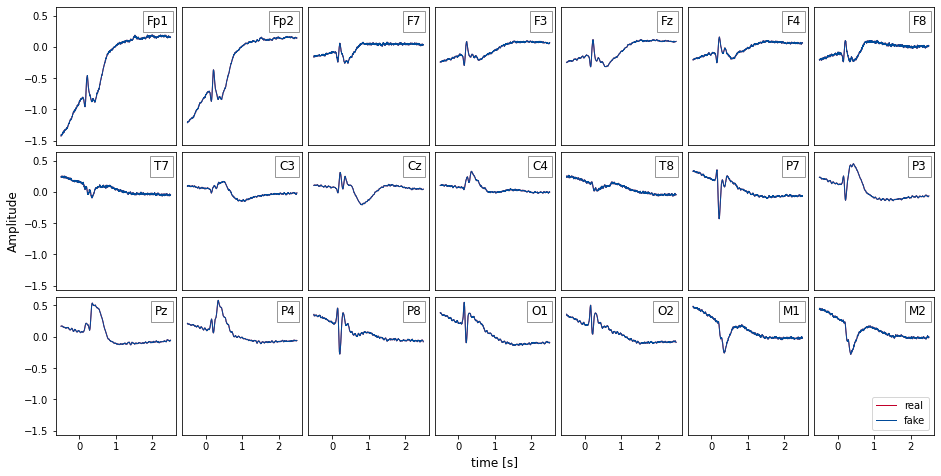

In [15]:
data = torch.load('/home/samuelboehm/reworkedGAN/Data/clinical')

channels = ['Fp1','Fp2','F7','F3','Fz','F4','F8',
            'T7','C3','Cz','C4','T8','P7','P3',
            'Pz','P4','P8','O1','O2','M1','M2']

plot_time_domain(data.data, data.data, channels, False)

In [16]:
data.data.shape

(6742, 21, 768)